# Модель для отслеживания комментариев

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на проверку. 

**Цель исследования** 

Обучить модель классифицировать комментарии на позитивные и негативные. 

**Ход исследования**

В вашем распоряжении набор данных с разметкой о токсичности правок. Прежде чем приступить к построению модели, подготовим данные для обучения.

Таким образом, исследование пройдёт в три этапа:
1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Выполнить анализ моделей.

Примечания:
- Для оценки качества моделей применим метрику F1.
- Значение метрики f1 должно быть не меньше 0.75.

## Подготовка

### Открытие файлов. Общее представление.

Импортируем библиотеки для работы в Питоне.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import nltk
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from lightgbm import LGBMClassifier

Откроем файл с данными и изучим общую информацию. Прочитаем файл и сохраним его в датасет. 

In [ ]:
try: 
    toxic_comments = pd.read_csv('/datasets/toxic_comments.csv')
except: 
    toxic_comments = pd.read_csv('toxic_comments.csv')

toxic_comments.head(5)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


В наборе данных имеется 159571 запись. Столбец text в нём содержит текст комментария, а toxic — целевой признак.

Рассмотрим подробнее столбец toxic. Проверим, как часто встречается класс «1» или «0». Количество уникальных значений подсчитаем методом value_counts().

In [ ]:
# ballance of target classes
toxic_comments['toxic'].value_counts(normalize=True)

0    0.898321
1    0.101679
Name: toxic, dtype: float64

Классы не сбалансированы, когда их соотношение далеко от 1:1. Класс «1» встречается реже, доля составляет только 10.2%. 

### Лемматизация


Прежде чем извлечь признаки из текста, упростим его. Выполним этапы предобработки текста:

-Токенизация (англ. tokenization) — разбиение текста на токены: отдельные фразы, слова, символы.

-Лемматизация (англ. lemmatization) — приведение слова к начальной форме — лемме.

От лишних символов текст очистят регулярные выражения (англ. regular expressions). re.sub - это инструмент для поиска слова или числа по шаблону. Он определяет, из каких частей состоит строка и какие в них символы. 

Создадим функцию с использованием spacy и re.sub, которая оставит в тексте только символы и пробелы, потом уберём лишние пробелы. На вход она принимает исходные данные, а возвращает очищенный текст. Проверим предобработку на одной строке.

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [ ]:
def lemma_by_spacy_clear(text):
    text = text.lower()
    text=re.sub(r'[^a-zA-Z ]',' ',text)
    doc = nlp(text)
    doc=" ".join([token.lemma_ for token in doc])
           
    return " ".join(doc.split())

In [ ]:
print("Исходный текст:", toxic_comments['text'][1])
print("Лемматизированный текст:", lemma_by_spacy_clear(toxic_comments['text'][1]))

Исходный текст: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Лемматизированный текст: d aww he match this background colour I m seemingly stick with thank talk january utc


Функция работает корректно. Обновим исходные данные: применим функцию для Лемматизации и для очистки.

In [ ]:
# lemmatization of data
toxic_comments['lemm_text'] = toxic_comments['text'].apply(lemma_by_spacy_clear)

In [ ]:
# updated data
toxic_comments_upd = toxic_comments[['lemm_text', 'toxic']].copy()

toxic_comments_upd.head()

,lemm_text,toxic
0,explanation why the edit make under my usernam...,0
1,d aww he match this background colour I m seem...,0
2,hey man I m really not try to edit war it s ju...,0
3,more I can t make any real suggestion on impro...,0
4,you sir be my hero any chance you remember wha...,0


Слова теперь в начальных формах. Функция выполнила лемматизацию корректно.

### Определение выборок



Столбец 'clear_text' будем называть - признаки. Признак, который нужно предсказать, — целевой: в нашей задаче это колонка 'toxic'.

Тестовой выборки нет. Значит, данные нужно разбить на две части: обучающую и тестовую. Сделаем тестовую выборку размером 25% от исходных данных. Определим параметр stratify, который сохранит пропорции классов для целевого признака во всех выборках. Зафиксируем псевдослучайность для алгоритма обучения, укажем параметр random_state.

In [ ]:
# train and valid sets for data
features_train, features_valid, target_train, target_valid = train_test_split(toxic_comments_upd['lemm_text'], toxic_comments_upd['toxic'], 
                                                    test_size=0.4, stratify=toxic_comments_upd['toxic'], random_state=123)

# test and valid sets for data
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, 
                                                                  random_state=123, stratify=target_valid)

### TF-IDF



Посмотрим, как часто уникальное слово встречается во всём корпусе и в отдельном его тексте. Оценка важности слова определяется величиной TF-IDF. То есть TF отвечает за количество упоминаний слова в отдельном тексте, а IDF отражает частоту его употребления во всём корпусе.

Определим стоп-слова, то есть слова без смысловой нагрузки. После этого нам будет проще найти слова, важные для классификации текстов.

In [ ]:
# stopwords definition
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Рассчитать TF-IDF можно и в библиотеке sklearn, класс TfidfVectorizer. Создадим счётчик, указав в нём стоп-слова, и вызовем функцию fit_transform(). Укажем параметр min_df=5, чтобы подсчет игнорировал редкие слова (редкие случаи - когда слова упоминаются менее, чем в 5 комментариях) .

In [ ]:
# counter tf-idf
count_tf_idf = TfidfVectorizer(stop_words=stopwords, min_df=5)

# tf-idf calculation
tf_idf_train = count_tf_idf.fit_transform(features_train)

Проверим размер исходной выборки и после подсчета TF-IDF.

In [ ]:
# train features shape
print(features_train.shape)
print(tf_idf_train.shape)

(95742,)
(95742, 20760)


Количество строк совпадает - все признаки после подсчета сохранены.

Функцию fit() запускаем только на обучающей. Иначе тестирование будет нечестным: в модели будут учтены частоты слов из валидационной выборки. Посчитаем TF-IDF для валидационной выборки, вызовем функцию transform(). 

In [ ]:
# tf-idf calculation
tf_idf_valid = count_tf_idf.transform(features_valid)

# test features shape
print(features_valid.shape)
print(tf_idf_valid.shape)

(31914,)
(31914, 20760)


Количество строк совпадает - все признаки после подсчета сохранены.

### Вывод



Мы получили архив с комментариями пользователей. В наборе данных имеется 159571 запись. Столбец text в нём содержит текст комментария, а toxic — целевой признак.

Классы целевого признака не сбалансированы. Класс «1» встречается реже, доля составляет только 10.2% от всех данных.

Выполнены этапы предобработки текста: Лемматизация и очистка. 

Подготовили три вида набора данных (обучающая, валидационная и тестовая выборки) для создания будущей модели.

Создали матрицы cо значениями TF-IDF для каждой выборки. Эти значения будем использовать как признаки для обучения/предсказания модели.

Выполненная обработка данных поможет нам точнее и быстрее обучить модель.

## Обучение

#### Изменение порога

Граница, где заканчивается отрицательный класс и начинается положительный, называется порогом. По умолчанию он равен 0.5. Изменим значение порога и посмотрим, какими станут метрики. В библиотеке sklearn вероятность классов вычисляет функция predict_proba(). На вход она получает признаки объектов, а возвращает вероятности. Создадим функцию для подбора порога для отбора лучшей метрики предсказаний модели.

In [ ]:
# function of threshold for f1 quality 

def thr(model, features_test, target_test):
    
    probabilities_test = model.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]

    for threshold in np.arange(0, 0.8, 0.1):
        predicted_test = probabilities_one_test > threshold
    
        result = f1_score(target_test, predicted_test)       
        
        print("Порог = {:.2f} | f1 = {:.5f},".format(threshold, result))

Исследуем качество моделей при разных порогах на валидационной выборке, используя полученную функцию.

#### Логистическая регрессия

In [ ]:
# model
model_log = LogisticRegression(solver='liblinear', random_state=123)

# model fit
model_log.fit(tf_idf_train, target_train)

# definition of quality for threshold
thr(model_log, tf_idf_valid, target_valid)

Порог = 0.00 | f1 = 0.18459,
Порог = 0.10 | f1 = 0.68307,
Порог = 0.20 | f1 = 0.77674,
Порог = 0.30 | f1 = 0.78270,
Порог = 0.40 | f1 = 0.76189,
Порог = 0.50 | f1 = 0.74352,
Порог = 0.60 | f1 = 0.71088,
Порог = 0.70 | f1 = 0.67044,


Качество модели максимально при пороге 0.3.

Придадим объектам редкого класса больший вес. Поменяем параметр на сбалансирование, укажем class_weight='balanced'.

In [ ]:
# model
model_log_ballance = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=123)


# model fit
model_log_ballance.fit(tf_idf_train, target_train)

# definition of quality for threshold
thr(model_log_ballance, tf_idf_valid, target_valid)

Порог = 0.00 | f1 = 0.18459,
Порог = 0.10 | f1 = 0.36733,
Порог = 0.20 | f1 = 0.52181,
Порог = 0.30 | f1 = 0.62984,
Порог = 0.40 | f1 = 0.70334,
Порог = 0.50 | f1 = 0.74815,
Порог = 0.60 | f1 = 0.77325,
Порог = 0.70 | f1 = 0.78162,


Сбалансирование модели не дает лучшего качества.

### LightGBM

In [ ]:
# model
model_LG = LGBMClassifier(random_state=123)

# model fit
model_LG.fit(tf_idf_train, target_train)

# definition of quality for threshold
thr(model_LG, tf_idf_valid, target_valid)

Порог = 0.00 | f1 = 0.18459,
Порог = 0.10 | f1 = 0.72583,
Порог = 0.20 | f1 = 0.77472,
Порог = 0.30 | f1 = 0.78109,
Порог = 0.40 | f1 = 0.76928,
Порог = 0.50 | f1 = 0.75973,
Порог = 0.60 | f1 = 0.73494,
Порог = 0.70 | f1 = 0.71104,


Качество модели максимально при пороге 0.3.

Придадим объектам редкого класса больший вес. Поменяем параметр на сбалансирование, укажем class_weight='balanced'.

In [ ]:
# model
model_LG_ballance = LGBMClassifier(class_weight='balanced', random_state=123)

# model fit
model_LG_ballance.fit(tf_idf_train, target_train)

# definition of quality for threshold
thr(model_LG_ballance, tf_idf_valid, target_valid)

Порог = 0.00 | f1 = 0.18459,
Порог = 0.10 | f1 = 0.27747,
Порог = 0.20 | f1 = 0.39131,
Порог = 0.30 | f1 = 0.51688,
Порог = 0.40 | f1 = 0.69007,
Порог = 0.50 | f1 = 0.74272,
Порог = 0.60 | f1 = 0.76251,
Порог = 0.70 | f1 = 0.76414,


Сбалансирование модели не дает лучшего качества.

### Случайный лес

In [ ]:
# model
model_RF= RandomForestClassifier(random_state=123)

# model fit
model_RF.fit(tf_idf_train, target_train)

# definition of quality for threshold
thr(model_RF, tf_idf_valid, target_valid)

Порог = 0.00 | f1 = 0.23328,
Порог = 0.10 | f1 = 0.65057,
Порог = 0.20 | f1 = 0.75416,
Порог = 0.30 | f1 = 0.78533,
Порог = 0.40 | f1 = 0.77759,
Порог = 0.50 | f1 = 0.75632,
Порог = 0.60 | f1 = 0.70910,
Порог = 0.70 | f1 = 0.64400,


Качество модели максимально при пороге 0.3.

Придадим объектам редкого класса больший вес. Поменяем параметр на сбалансирование, укажем class_weight='balanced'.

In [ ]:
# model
model_RF_ballance = RandomForestClassifier(class_weight='balanced', random_state=123)

# model fit
model_RF_ballance.fit(tf_idf_train, target_train)

# definition of quality for threshold
thr(model_RF_ballance, tf_idf_valid, target_valid)

Порог = 0.00 | f1 = 0.21608,
Порог = 0.10 | f1 = 0.59108,
Порог = 0.20 | f1 = 0.70612,
Порог = 0.30 | f1 = 0.73401,
Порог = 0.40 | f1 = 0.71976,
Порог = 0.50 | f1 = 0.67532,
Порог = 0.60 | f1 = 0.62048,
Порог = 0.70 | f1 = 0.51573,


Сбалансирование модели не дает лучшего качества.

### Вывод



Все рассматриваемые модели делают наиболее точные предсказания при пороге 0.3. Качество по метрике f1 около 0.78.

Сбалансирование модели (class_weight='balanced') не дает лучшего качества предсказаний.

## Тест и Анализ

### Объединенная выборка



Подбор порога моделей был выполнен, поэтому можем объединить тренировочный и валидационные выборки. Выбранная модель обучится на большем количестве данных, что положительно скажется на финальных метриках.

In [ ]:
# concatenate train and valid sets
features_train_upd = pd.concat([features_train, features_valid])
target_train_upd = pd.concat([target_train, target_valid])
    
features_train_upd = shuffle(features_train_upd, random_state=123)
target_train_upd = shuffle(target_train_upd, random_state=123)

print(f'Размер объединенной выборки для признаков: {features_train_upd.shape}')
print(f'Размер объединенной выборки для целевого признака: {target_train_upd.shape}')
print(f'Размер исходной выборки для признаков: {features_train.shape}')

Размер объединенной выборки для признаков: (127656,)
Размер объединенной выборки для целевого признака: (127656,)
Размер исходной выборки для признаков: (95742,)


Посчитаем TF-IDF для объединенной выборки.

In [ ]:
# tf-idf calculation
tf_idf_train_upd = count_tf_idf.fit_transform(features_train_upd)

Функцию fit() запускаем только на обучающей. Иначе тестирование будет нечестным: в модели будут учтены частоты слов из тестовой выборки. Посчитаем TF-IDF для тестовой выборки, вызовем функцию transform(). 

In [ ]:
# tf-idf calculation
tf_idf_test = count_tf_idf.transform(features_test)

Проверим размер исходной выборки и после подсчета TF-IDF.

In [ ]:
# train features shape
print(features_train_upd.shape)
print(tf_idf_train_upd.shape)

(127656,)
(127656, 24634)


In [ ]:
# test features shape
print(features_test.shape)
print(tf_idf_test.shape)

(31915,)
(31915, 24634)


Количество строк совпадает - все признаки после подсчета сохранены.

### Тест моделей



Чтобы знать точно, как предсказывает модель, возьмём новый датасет — тестовый набор данных. Проверим, как модели при лучшем пороге справятся с ним.

Создадим функцию для предсказания модели с полученным порогом для отбора лучшего качества по метрики f1.

In [ ]:
# threshold with best model predict quality
threshold = .3

# function for model test
def test(model, threshold, features_test, target_test):
  pred_proba = model.predict_proba(features_test)
  predicted = (pred_proba[:,1] >= threshold).astype('int')
  
  return f1_score(target_test, predicted)

#### Логистическая регрессия

In [ ]:
%%time

# model fit
model_log.fit(tf_idf_train_upd, target_train_upd)

# model test, f1 metric
f1_log = test(model_log, threshold, tf_idf_test, target_test)

print('f1 на тесте равно', f1_log)

f1 на тесте равно 0.782380013149244
CPU times: user 1.47 s, sys: 1.1 s, total: 2.58 s
Wall time: 1.39 s


#### LightGBM

In [ ]:
%%time

# model fit
model_LG.fit(tf_idf_train_upd, target_train_upd)

# model test, f1 metric
f1_LG = test(model_LG, threshold, tf_idf_test, target_test)

print('f1 на тесте равно', f1_LG)

f1 на тесте равно 0.7797277349516154
CPU times: user 2min 6s, sys: 877 ms, total: 2min 7s
Wall time: 1min 6s


#### Случайный лес

In [ ]:
%%time

# model fit
model_RF.fit(tf_idf_train_upd, target_train_upd)

# model test, f1 metric
f1_RF = test(model_RF, threshold, tf_idf_test, target_test)

print('f1 на тесте равно', f1_RF)

f1 на тесте равно 0.7855822550831794
CPU times: user 5min 37s, sys: 399 ms, total: 5min 38s
Wall time: 5min 36s


Лучше всего предсказывает модель, обученная методом Случайный лес. Качество по метрики f1 равно 0.786 на тестовой выборке.

### AUC-ROC 



В результате исследования мы получили модели с необходимой точностью по f1. Проведем анализ моделей с помощью метрики AUC-ROC, посчитаем площадь под ROC-кривой. Напишем функцию для подсчета AUC-ROC, которая вернет вероятность класса "1". 

In [ ]:
# function for probabilities of class one

def proba_one(model, features_test):
  proba_test = model.predict_proba(features_test)
  proba_one = proba_test[:, 1]
  return proba_one

In [ ]:
# score auc_roc for models

proba_one_log = proba_one(model_log, tf_idf_test)
auc_roc_log = roc_auc_score(target_test, proba_one_log)
print(f'Логистическая регрессия. AUC-ROC = {auc_roc_log:.5}')

proba_one_LG = proba_one(model_LG, tf_idf_test)
auc_roc_LG = roc_auc_score(target_test, proba_one_LG)
print(f'LightGBM. AUC-ROC = {auc_roc_LG:.5}')

proba_one_RF = proba_one(model_RF, tf_idf_test)
auc_roc_RF = roc_auc_score(target_test, proba_one_RF)
print(f'Случайный лес. AUC-ROC = {auc_roc_RF:.5}')

Логистическая регрессия. AUC-ROC = 0.97165
LightGBM. AUC-ROC = 0.96453
Случайный лес. AUC-ROC = 0.96534


Выполним построение ROC-кривой для каждой модели. Для модели, которая всегда отвечает случайно, ROC-кривая выглядит как прямая, идущая из левого нижнего угла в верхний правый.

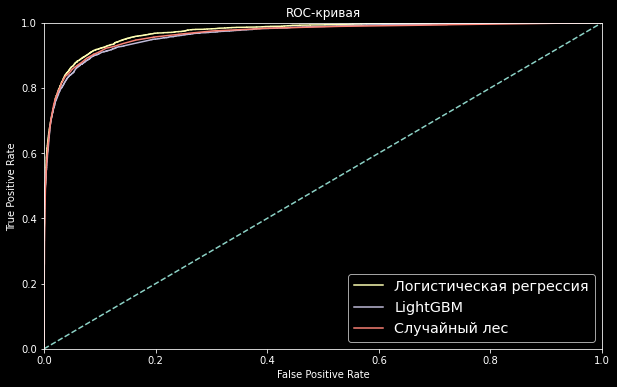

In [ ]:
# ROC-curve for random model
plt.style.use('dark_background')
plt.figure(figsize=[10,6])
plt.plot([0, 1], [0, 1], linestyle='--')

# ROC-curve for models

fpr, tpr, thresholds = roc_curve(target_test, proba_one_log)
plt.plot(fpr, tpr,  label='Логистическая регрессия')

fpr, tpr, thresholds = roc_curve(target_test, proba_one_LG)
plt.plot(fpr, tpr,  label='LightGBM')

fpr, tpr, thresholds = roc_curve(target_test, proba_one_RF)
plt.plot(fpr, tpr,  label='Случайный лес')


# plot visual details

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')
plt.legend(loc='lower right', fontsize='x-large')
plt.show()

Логистическая регрессия лидер по метрике: AUC-ROC до 0.97.

## Вывод 

Мы получили архив с комментариями пользователей. В наборе данных имеется 159571 запись. Столбец text в нём содержит текст комментария, а toxic — целевой признак.

Выполнены этапы предобработки текста: Лемматизация и очистка.

Создали матрицы cо значениями TF-IDF. Эти значения использовали как признаки для обучения/предсказания модели.

Лучше всего предсказывает модель, обученная методом Случайный лес. Качество по метрики f1 равно 0.786 на тестовой выборке.

Метрика f1 указывает на качество при конкретном пороге. Если показатели AUC-ROC и f1 высокие, то модель можно считать успешной. Скорость работы не менее значимый критерий. Сделаем сводную таблицу по результатам исследования.

In [ ]:
pd.DataFrame({'модель':['Логистическая регрессия', 'LightGBM', 
                        'Случайный лес'],
              'f1':[f1_log, f1_LG, f1_RF],
              'AUC-ROC':[auc_roc_log, auc_roc_LG, auc_roc_RF],
             'скорость':['высокая', 'средняя', 'низкая']})

,модель,f1,AUC-ROC,скорость
0,Логистическая регрессия,0.782380,0.971646,высокая
1,LightGBM,0.779728,0.964526,средняя
2,Случайный лес,0.785582,0.965337,низкая
